In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as plt
import os
import time
import keras
import imghdr
import random

from matplotlib import pyplot as plt
from pathlib import Path
from keras import layers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/var/folders/27/7ktdl51577s6mfwmc_b91fyw0000gn/T/ipykernel_46091/1436632955.py:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Scrape images from the web

In [ ]:
from image_scraper import scrape_google_images

food_categories = [
    'pizza', 'hamburger', 'sushi', 'tacos', 
    'spaghetti', 'salad', 'chickenwings', 'steak', 
    'lobster','frenchfries', 'dumplings', 'salmon', 
    'ramen', 'brownies', 'burrito', 'pancakes', 
    'nachos','popcorn','hotdog','omelette',
    'icecream', 'donuts', 'sandwich', 'cake', 'curry',
    'cookies', 'rice', 'croissant', 'chowmein', 'porkchop'
]

data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

num_images_per_category = 600

for category in food_categories:
    print(f"\n Scraping images for: {category}")
    
    # create new subdirectory in data directory
    category_dir = os.path.join(data_dir, category)
    
    # create multiple search queries to generate relevant images
    search_queries = [
        f"{category} food",
        f"{category} delicious",
        f"{category} recipe"
    ]

    for search_query in search_queries:
        try:
            scrape_google_images(search_query, num_images_per_category, category_dir)
            print(f"Completed scraping for {search_query}")
            
            time.sleep(1)
            
        except Exception as e:
            print(f"Error scraping {category}: {str(e)}")
            continue

# summary of scraped images
print("\nSummary of scraped images:")
for category in food_categories:
    category_path = os.path.join(data_dir, category)
    if os.path.exists(category_path):
        image_count = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        print(f"{category}: {image_count} images")
    else:
        print(f"{category}: Directory not found")

# Data Cleaning

In [ ]:
# quick cleanup of bad/tiny images
def quick_cleanup(data_dir):
    bad_files = 0
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Remove very small files (less than 1 KB)
            if os.path.getsize(file_path) < 1024:
                print(f"Removing tiny file: {file}")
                os.remove(file_path)
                bad_files += 1
            # remove files without proper extensions
            elif not file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                print(f"Removing non-image file: {file}")
                os.remove(file_path)
                bad_files += 1
    
    print(f"Removed {bad_files} problematic files")

quick_cleanup('data')

# remove files not supported by tensorflow
data_dir = 'data'
image_extensions = [".png", ".jpg", ".jpeg", ".bmp", ".gif"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
deleted_count = 0

print("Checking and cleaning files not accepted by TensorFlow...")

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        
        if img_type is None:
            print(f"Deleting: {filepath} - not a valid image")
            os.remove(filepath)
            deleted_count += 1
            
        elif img_type not in img_type_accepted_by_tf:
            print(f"Deleting: {filepath} - format '{img_type}' not accepted by TensorFlow")
            os.remove(filepath)
            deleted_count += 1

print(f"\nDeleted {deleted_count} files that were not accepted by TensorFlow")

Checking and cleaning files not accepted by TensorFlow...
Deleting: data/popcorn/popcorn_food_9.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_27.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_33.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_32.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_26.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_30.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_24.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_18.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_19.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_25.jpg - format 'webp' not accepted by TensorFlow
Deleting: data/popcorn/popcorn_food_31.jpg - format 'webp' not accepted by TensorFl

# Load Data

In [3]:
random.seed(66)
np.random.seed(66)
tf.random.set_seed(66)

def count_data_subdirectories(data_dir='data'):
    if not os.path.exists(data_dir):
        print(f"Directory '{data_dir}' does not exist.")
        return 0
    
    subdirs = [d for d in os.listdir(data_dir) 
               if os.path.isdir(os.path.join(data_dir, d))]
    
    return len(subdirs)

num_classes = count_data_subdirectories()

data = keras.utils.image_dataset_from_directory(
    'data',
    batch_size=32,
    image_size=(256, 256),
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
    follow_links=False,
    verbose=False)

# split images into batches of 32 for faster training
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

Let's take a quick look at some sample images from the dataset.

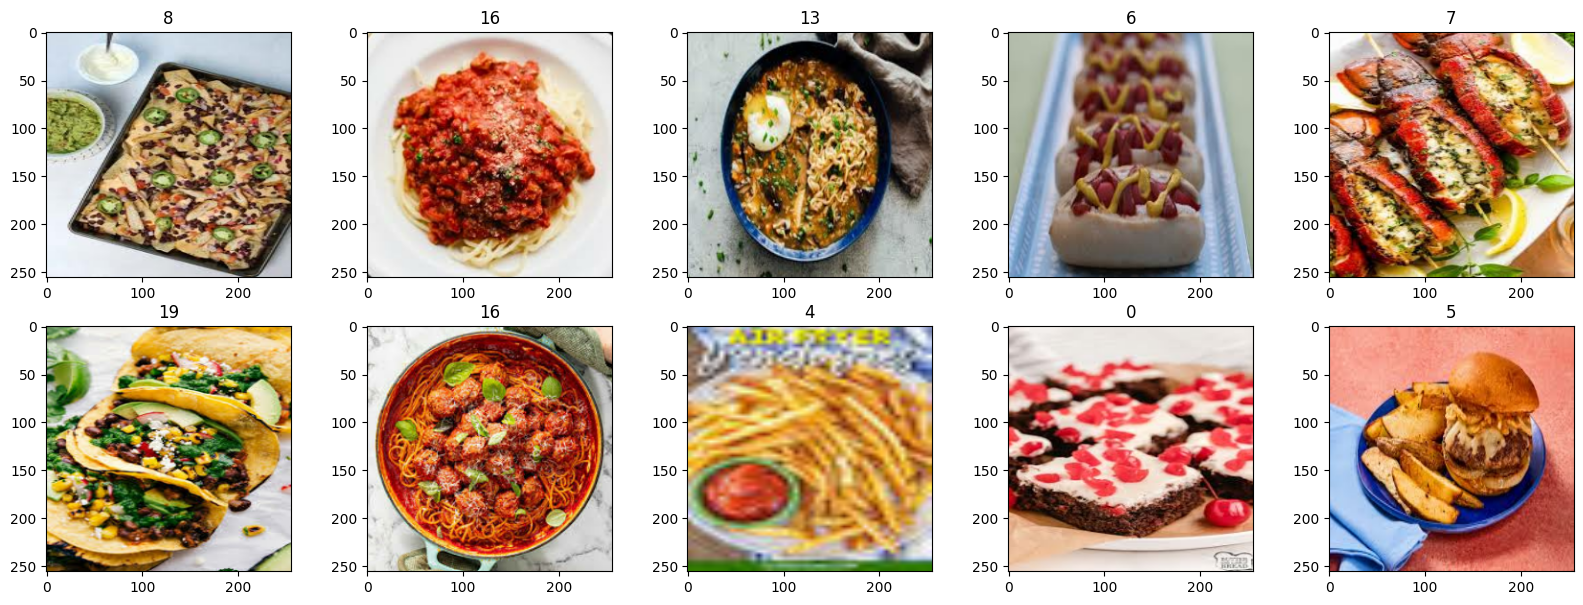

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))

for idx, img in enumerate(batch[0][:10]):
    ax[idx//5, idx%5].imshow(img.astype(int))
    ax[idx//5, idx%5].title.set_text(batch[1][idx])

Due to the nature of scraping images from the web, some of the images are not good representations of their respective category. Some of the images are also low resolution. Hopefully, having a large enough training data size (~900 images per category) will mitigate the effects of these bad images. If they continue to be an issue, I can manually inspect each image and delete the bad ones.

# Preprocessing

In [ ]:
# scale images, set rgb values to between 0 and 1
data_scaled = data.map(lambda x, y : (x/255, y))
data_scaled.as_numpy_iterator().next()

Each image is a (256, 256, 3) 3 dimensional array, which is 256 pixels high and 256 pixels wide with an RGB value from 0 to 255 for each pixel. For more efficient training, I will standardize the RGB values to be between 0 and 1.

In [6]:
num_batches = len(data_scaled)

# create training, validation, testing sets
# use 70-20-10 split
train_size = int(num_batches * 0.7)
test_size = int(num_batches * 0.1)
val_size = num_batches - train_size - test_size

print(f'Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}')

train = data_scaled.take(train_size)
test = data_scaled.skip(train_size).take(test_size)
val = data_scaled.skip(train_size + test_size).take(val_size)

Train size: 406, Validation size: 117, Test size: 58


# Baseline CNN Model

For the baseline model, I will use a simple architecture using 3 convolutional layers with pooling layers, followed by a dense layer and classification layer.

**Convolutional layers:** These layers apply learnable filters to detect features like edges, textures, and patterns in the input image. Each convolutional layer produces feature maps that highlight different aspects of the image.

**Pooling layers:** A pooling layer is a downsampling operation that reduces the spatial dimensions (height and width) of feature maps while retaining the most important information, typically using operations like max pooling (taking the maximum value) or average pooling (taking the mean value) within a sliding window. This helps reduce computational complexity, control overfitting, and provides translation invariance by making the network less sensitive to small shifts in the input image.

**Flatten:** This layer converts the multi-dimensional feature maps from the convolutional layers into a single flat vector. This transformation is necessary to connect the convolutional layers to the fully connected dense layers.

**Dropout:** Dropout randomly sets a fraction of input units to zero during training to prevent overfitting. This regularization technique forces the model to not rely too heavily on specific neurons and improves generalization.

**Dense layer:** A fully connected layer where each neuron connects to every neuron in the previous layer, learning complex patterns from the flattened features. This layer acts as a classifier that combines all the learned features to make decisions.

**Classification layer:** The final dense layer with softmax activation that outputs probability distributions over all possible classes. The number of neurons in this layer equals the number of classes, and the neuron with the highest probability represents the model's prediction.

For training metrics, I will use the Adam optimizer which is commonly used for image classification tasks. For multi classification problems, the loss function typically used is sparse categorical crossentropy. The optimizer will try to minimize this loss function by using its gradient to look for its minimum.

In [7]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model_baseline = Sequential([
    # first convolutional layer
    Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(2,2),
    # second convolutional layer
    Conv2D(64, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    # third convolutional layer
    Conv2D(128, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    # flatten and dense layers
    Flatten(),
    # dropout to reduce overfitting
    Dropout(0.5),
    Dense(256, activation='relu'),
    # more dropout before classification
    Dropout(0.3),
    # classification layer
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model_baseline.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model_baseline.summary()

/Users/davidpan/Desktop/repos/CNN/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,589,844 (112.88 MB)

 Trainable params: 29,589,844 (112.88 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from keras.callbacks import EarlyStopping

# training will stop early if val_loss not seeing improvement
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

logdir = 'logs'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history_baseline = model_baseline.fit(
    train,
    epochs=50,
    validation_data=val,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 66s 158ms/step - accuracy: 0.1173 - loss: 2.8999 - val_accuracy: 0.2597 - val_loss: 2.5150
Epoch 2/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 66s 158ms/step - accuracy: 0.1173 - loss: 2.8999 - val_accuracy: 0.2597 - val_loss: 2.5150
Epoch 2/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 61s 149ms/step - accuracy: 0.2220 - loss: 2.5827 - val_accuracy: 0.3435 - val_loss: 2.2395
Epoch 3/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 61s 149ms/step - accuracy: 0.2220 - loss: 2.5827 - val_accuracy: 0.3435 - val_loss: 2.2395
Epoch 3/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 62s 153ms/step - accuracy: 0.2859 - loss: 2.4515 - val_accuracy: 0.3680 - val_loss: 2.1532
Epoch 4/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 62s 153ms/step - accuracy: 0.2859 - loss: 2.4515 - val_accuracy: 0.3680 - val_loss: 2.1532
Epoch 4/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 62s 153ms/step - accuracy: 0.3121 - loss: 2.4762 - val_accuracy: 0.3991 - val_loss: 2.0962
Epoch 5/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 62s 153ms/step - accuracy: 0.3121 - loss: 2

It looks like the baseline model gets stuck at around 40% accuracy, which is not bad considering the number of different classes. Let's visualize how the loss and accuracy improved over the training period.

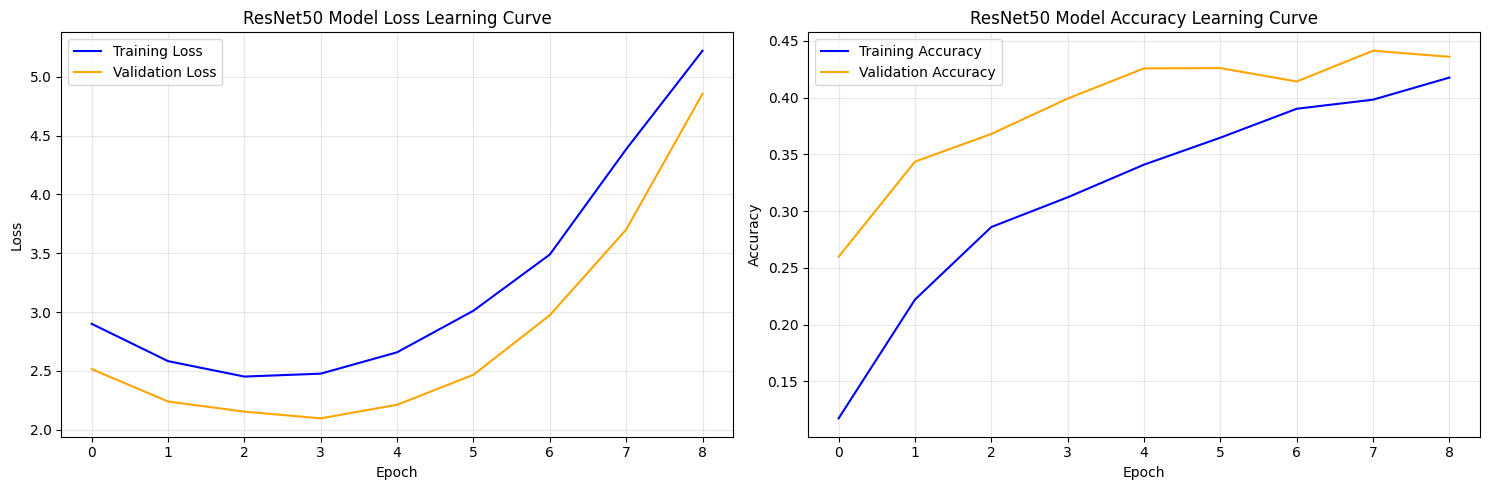

In [9]:
# side by side learning rate curves for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot loss
ax1.plot(history_baseline.history['loss'], color='blue', label='Training Loss')
ax1.plot(history_baseline.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('ResNet50 Model Loss Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot accuracy
ax2.plot(history_baseline.history['accuracy'], color='blue', label='Training Accuracy')
ax2.plot(history_baseline.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('ResNet50 Model Accuracy Learning Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Using the accuracy metric, lets see how the model performs on new, unseen data.

In [10]:
from keras.metrics import CategoricalAccuracy

accuracy = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    y = tf.one_hot(y, num_classes)
    y_pred = model_baseline.predict(X)
    accuracy.update_state(y, y_pred)
    
print(f'Baseline accuracy: {accuracy.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━

In [11]:
from keras.models import load_model

# we can save and load models for future use without needing to retrain
model_baseline.save(os.path.join('models', 'model_baseline.keras'))
model_baseline = load_model(os.path.join('models', 'model_baseline.keras'))

# Transfer Learning

I will be using the pretrained ResNet50 model for image classification to improve upon my baseline. ResNet50 takes in inputs from [0, 255] instead of [0, 1], so I need to rescale my data back to original

In [114]:
from keras.applications.resnet50 import preprocess_input

def rescale_resnet(x, y):
    x = preprocess_input(x)
    return x, y

data_resnet = data.map(rescale_resnet)

# verify preprocessing
for batch_x, batch_y in data_resnet.take(1):
    print(f"ResNet data range: {tf.reduce_min(batch_x)} to {tf.reduce_max(batch_x)}")
    print(f"ResNet data shape: {batch_x.shape}")

train_resnet = data_resnet.take(train_size)
test_resnet = data_resnet.skip(train_size).take(test_size)
val_resnet = data_resnet.skip(train_size + test_size).take(val_size)

ResNet data range: -123.68000030517578 to 151.06100463867188
ResNet data shape: (32, 256, 256, 3)


For this model, I will be introducing 2 more layers: global pooling and batch normalization.

**Global pooling:** This layer computes a single value from each feature map by taking the average (or maximum) across all spatial dimensions, effectively reducing each feature map to a single number. This eliminates the need for a flatten layer and dramatically reduces the number of parameters while maintaining important feature information.

**Batch normalization:** This layer normalizes the inputs to have zero mean and unit variance across each batch, which helps stabilize and accelerate training. It reduces internal covariate shift and allows the use of higher learning rates while acting as a form of regularization.

Since the model has partially already been pretrained, I can use a higher learning rate to hopefully approach the minimum of the loss function faster.

In [115]:
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, BatchNormalization

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling=None
)

# freeze base model layers
base_model.trainable = False

model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# use higher learning rate for transfer learning
optimizer_resnet = Adam(learning_rate=0.001)
model_resnet.compile(
    optimizer=optimizer_resnet,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model_resnet.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,117,396 (92.00 MB)

 Trainable params: 529,684 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from keras.callbacks import ModelCheckpoint

# setup callbacks
early_stopping_resnet = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint_resnet = keras.callbacks.ModelCheckpoint(
    'models/model_resnet50.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# train model
history_resnet = model_resnet.fit(
    train_resnet,
    epochs=50,
    validation_data=val_resnet,
    callbacks=[early_stopping_resnet, checkpoint_resnet],
    verbose=1
)

Epoch 1/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.3391 - loss: 3.8731
Epoch 1: val_accuracy improved from None to 0.71851, saving model to best_resnet50_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 114s 267ms/step - accuracy: 0.4454 - loss: 3.2739 - val_accuracy: 0.7185 - val_loss: 1.1805
Epoch 2/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5716 - loss: 2.4391
Epoch 2: val_accuracy improved from 0.71851 to 0.76659, saving model to best_resnet50_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 107s 263ms/step - accuracy: 0.5863 - loss: 2.3197 - val_accuracy: 0.7666 - val_loss: 1.0251
Epoch 3/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6344 - loss: 1.9464
Epoch 3: val_accuracy improved from 0.76659 to 0.77894, saving model to best_resnet50_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 127s 312ms/step - accuracy: 0.6355 - loss: 1.8772 - val_accuracy: 0.7789 - val_loss: 0.9635
Epoch 4/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.6556 - loss: 1

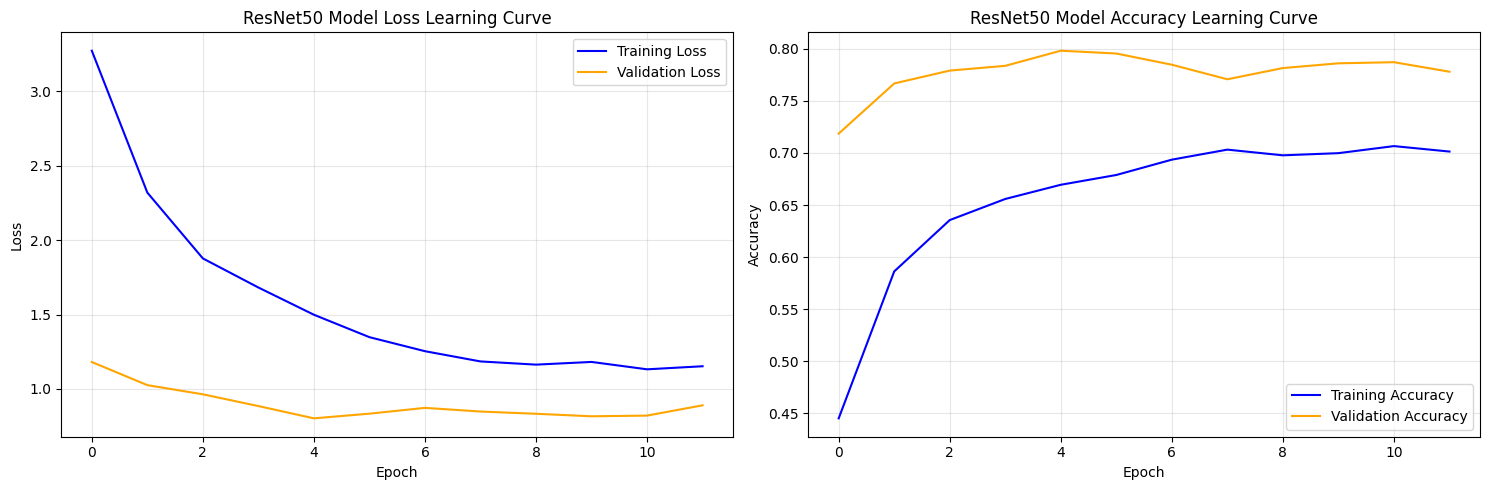

In [80]:
# side by side learning rate curves for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot loss
ax1.plot(history_resnet.history['loss'], color='blue', label='Training Loss')
ax1.plot(history_resnet.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('ResNet50 Model Loss Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot accuracy
ax2.plot(history_resnet.history['accuracy'], color='blue', label='Training Accuracy')
ax2.plot(history_resnet.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('ResNet50 Model Accuracy Learning Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [84]:
accuracy_resnet = CategoricalAccuracy()

for batch in test_resnet.as_numpy_iterator():
    X, y = batch
    y = tf.one_hot(y, num_classes)
    y_pred = model_resnet.predict(X)
    accuracy_resnet.update_state(y, y_pred)
    
print(f'Transfer learning accuracy: {accuracy_resnet.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

The testing accuracy nearly doubled after implementing transfer learning! Let's see if we can achieve closer to 90% accuracy.

In [105]:
# save model
model_resnet.save(os.path.join('models', 'model_resnet.keras'))
model_resnet = load_model(os.path.join('models', 'model_resnet.keras'))

# Data Augmentation

I will be using augmentations to the training images, such as random flips and rotations, to artificially increase the size of our training data and make the model more robust to unseen images. This should reduce overfitting and lead to higher accuracy since the model will be trained on a much more diverse set of images.

In [ ]:
# load data without scaling for augmentation
data_for_aug = keras.utils.image_dataset_from_directory(
    'data',
    batch_size=32,
    image_size=(256, 256),
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
    follow_links=False,
    verbose=False
)

# split the unscaled data using the same 70-20-10 split
train_aug = data_for_aug.take(train_size)
test_aug = data_for_aug.skip(train_size).take(test_size)  
val_aug = data_for_aug.skip(train_size + test_size).take(val_size)

For data augmentation, I will be using 5 different augmentation techniques to artificially expand the training dataset and improve model robustness:

**RandomFlip('horizontal'):** Randomly flips images horizontally (left-right) with a 50% probability, helping the model learn that food appearance shouldn't depend on orientation. This is particularly useful for food images since dishes can be photographed from either side.

**RandomRotation(0.15):** Randomly rotates images by up to 15 degrees in either direction, simulating different camera angles. This helps the model become invariant to slight rotations that commonly occur in real-world photography.

**RandomZoom(0.1):** Randomly zooms in or out by up to 10%, creating variations in the apparent size of food items. This teaches the model to recognize foods regardless of how close or far the camera was when taking the photo.

**RandomContrast(0.1):** Randomly adjusts image contrast by up to 10%, simulating different lighting conditions and camera settings. This helps the model perform well under various lighting scenarios.

**RandomBrightness(0.1):** Randomly adjusts image brightness by up to 10%, accounting for different lighting conditions from bright restaurant lighting to dim ambient lighting. This improves model robustness across different photographic conditions.

In [119]:
from keras.layers import BatchNormalization

augmentation_layers = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

base_model_aug = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling=None
)
base_model_aug.trainable = False

model_aug = keras.Sequential([
    augmentation_layers,
    # augment first, then preprocess
    layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x)),
    base_model_aug,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

optimizer_aug = Adam(learning_rate=0.001)
model_aug.compile(
    optimizer=optimizer_aug,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model_aug.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [120]:
# setup callbacks
callbacks_aug = [
    # stops training if validation accuracy not showing improvement
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True
    ),
    # switch to smaller learning rate if stuck
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=7,
        factor=0.5,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'models/model_aug.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# initial training
history_aug = model_aug.fit(
    train_aug,
    epochs=50,
    validation_data=val_aug,
    callbacks=callbacks_aug,
    verbose=1
)

Epoch 1/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 159s 370ms/step - accuracy: 0.5318 - loss: 1.8322 - val_accuracy: 0.7330 - val_loss: 0.9360 - learning_rate: 0.0010
Epoch 2/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 145s 358ms/step - accuracy: 0.6222 - loss: 1.3867 - val_accuracy: 0.7674 - val_loss: 0.8225 - learning_rate: 0.0010
Epoch 3/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 146s 359ms/step - accuracy: 0.6454 - loss: 1.2829 - val_accuracy: 0.7784 - val_loss: 0.7630 - learning_rate: 0.0010
Epoch 4/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 144s 355ms/step - accuracy: 0.6597 - loss: 1.2250 - val_accuracy: 0.7768 - val_loss: 0.7790 - learning_rate: 0.0010
Epoch 5/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 144s 356ms/step - accuracy: 0.6693 - loss: 1.1893 - val_accuracy: 0.7730 - val_loss: 0.7718 - learning_rate: 0.0010
Epoch 6/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 145s 357ms/step - accuracy: 0.6672 - loss: 1.1632 - val_accuracy: 0.7878 - val_loss: 0.7383 - learning_rate: 0.0010
Epoch 7/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 146s 360ms/step - accura

## Fine-tuning

After the initial training phase with frozen ResNet50 layers, I will now perform fine-tuning by unfreezing the top 20 layers of the pre-trained model. This allows the model to adapt the high-level features learned on ImageNet to be more specific to food classification, while keeping the lower-level feature extractors frozen to prevent overfitting. I'll use a much lower learning rate (0.0001) during fine-tuning to make small, careful adjustments to the pre-trained weights.

In [122]:
# unfreeze some layers for fine-tuning
base_model_aug.trainable = True

# freeze bottom layers, unfreeze top layers
for layer in base_model_aug.layers[:-20]:
    layer.trainable = False

# recompile with lower learning rate
model_aug.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# fine-tune for a couple more epochs
history_fine = model_aug.fit(
    train_aug,
    epochs=20,
    validation_data=val_aug,
    callbacks=callbacks_aug,
    verbose=1
)

Epoch 1/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 162s 368ms/step - accuracy: 0.7469 - loss: 0.8647 - val_accuracy: 0.8378 - val_loss: 0.5772 - learning_rate: 1.0000e-04
Epoch 2/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 141s 346ms/step - accuracy: 0.7915 - loss: 0.7135 - val_accuracy: 0.8630 - val_loss: 0.4926 - learning_rate: 1.0000e-04
Epoch 3/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 140s 344ms/step - accuracy: 0.8276 - loss: 0.5882 - val_accuracy: 0.8525 - val_loss: 0.5289 - learning_rate: 1.0000e-04
Epoch 4/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 140s 344ms/step - accuracy: 0.8431 - loss: 0.5333 - val_accuracy: 0.8772 - val_loss: 0.4449 - learning_rate: 1.0000e-04
Epoch 5/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 140s 344ms/step - accuracy: 0.8618 - loss: 0.4619 - val_accuracy: 0.8724 - val_loss: 0.4487 - learning_rate: 1.0000e-04
Epoch 6/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 139s 343ms/step - accuracy: 0.8720 - loss: 0.4222 - val_accuracy: 0.8772 - val_loss: 0.4529 - learning_rate: 1.0000e-04
Epoch 7/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 

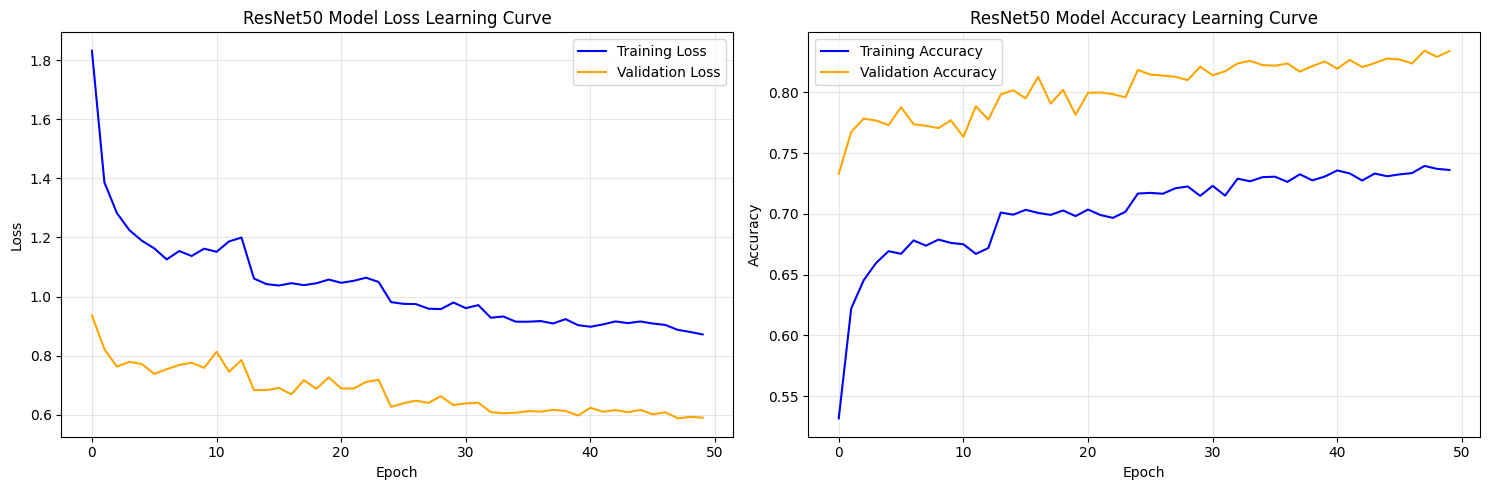

In [129]:
# side by side learning rate curves for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot loss
ax1.plot(history_aug.history['loss'], color='blue', label='Training Loss')
ax1.plot(history_aug.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('ResNet50 Model Loss Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot accuracy
ax2.plot(history_aug.history['accuracy'], color='blue', label='Training Accuracy')
ax2.plot(history_aug.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('ResNet50 Model Accuracy Learning Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [123]:
accuracy_aug = CategoricalAccuracy()

for batch in test_aug.as_numpy_iterator():
    X, y = batch
    y = tf.one_hot(y, num_classes)
    y_pred = model_aug.predict(X)
    accuracy_resnet.update_state(y, y_pred)
    
print(f'Transfer learning accuracy: {accuracy_resnet.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Using data augmentation and transfer model fine tuning, I was able to squeeze out another ~5% accuracy in the model.

In [ ]:
# save model
model_aug.save(os.path.join('models', 'model_aug.keras'))
model_aug = load_model(os.path.join('models', 'model_aug.keras'))

Test time augmentation can help the model make better predictions by essentially giving it multiple 'angles' of the same image, allowing it to see different perspectives before making a classification.

In [127]:
# Test Time Augmentation
def test_time_augmentation(model, image_batch, num_augmentations=10):
    """Apply TTA and return averaged predictions"""
    predictions = []
    
    # Conservative augmentation for TTA
    tta_aug = keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.05),
        layers.RandomContrast(0.05),
    ])
    
    # Generate multiple augmented predictions
    for _ in range(num_augmentations):
        aug_batch = tta_aug(image_batch, training=True)
        predictions.append(model.predict(aug_batch, verbose=0))
    
    return np.mean(predictions, axis=0)

def evaluate_with_tta(model, test_dataset):
    """Evaluate model with TTA"""
    accuracy_tta = CategoricalAccuracy()
    
    for batch_x, batch_y in test_dataset:
        y = tf.one_hot(batch_y, num_classes)
        y_pred = test_time_augmentation(model, batch_x)
        accuracy_tta.update_state(y, y_pred)
    
    return accuracy_tta.result().numpy()

# Evaluate augmented model with TTA
tta_accuracy = evaluate_with_tta(model_aug, test_aug)
print(f"TTA accuracy: {tta_accuracy:.4f}")

TTA accuracy: 0.9240


By implementing test time augmentations, the accuracy of the model improved to over 90%.

# Model Performance Analysis

I am curious to find out which classes the model is best at predicting as well as which classes it is worst at predicting. For the worst predicted classes, I want to know which classes the model tends to mispredict them as.

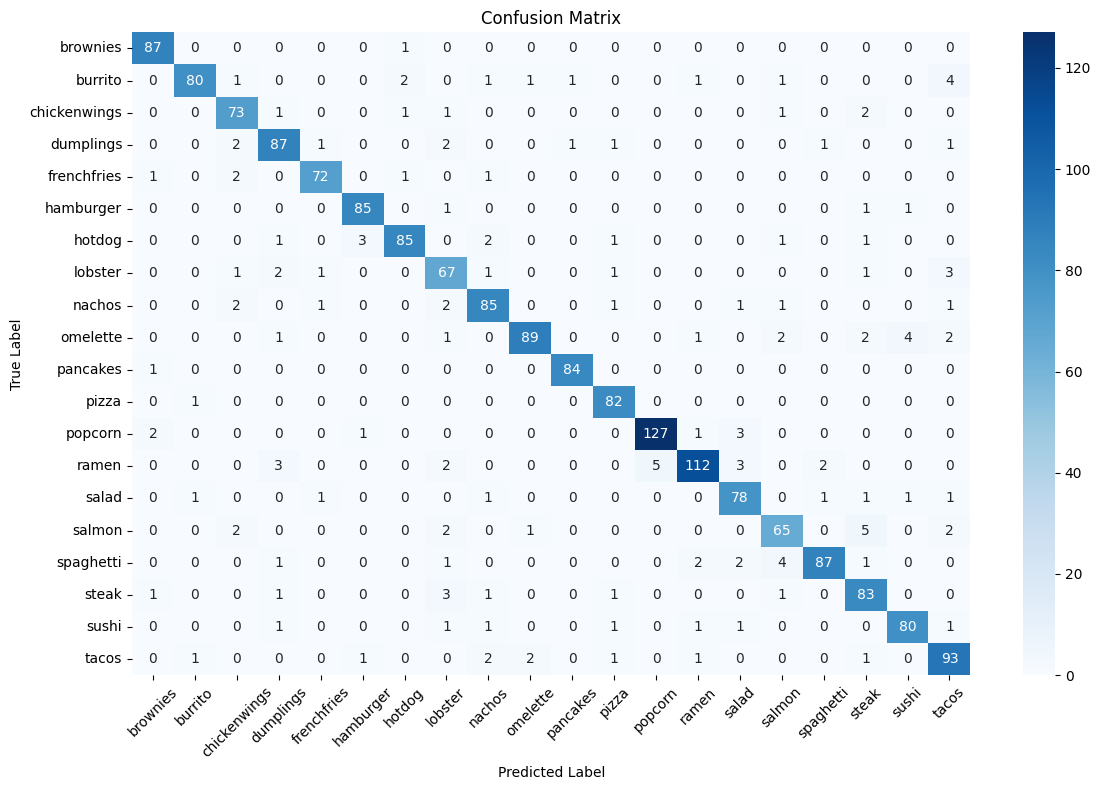

In [138]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class_names = sorted([d for d in os.listdir('data') if os.path.isdir(os.path.join('data', d))])

all_predictions = []
all_labels = []

for batch_x, batch_y in test_aug:
    y_pred = model_aug.predict(batch_x, verbose=0)
    all_predictions.append(y_pred)
    all_labels.append(batch_y.numpy())

predictions = np.vstack(all_predictions)
labels = np.concatenate(all_labels)
predicted_classes = np.argmax(predictions, axis=1)

# generate classification report and confusion matrix
report = classification_report(labels, predicted_classes, target_names=class_names, output_dict=True)
cm = confusion_matrix(labels, predicted_classes)

# plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Which classes does the model struggle most in predicting?

In [141]:
misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 0:
            misclassifications.append({
                'true': class_names[i],
                'predicted': class_names[j],
                'count': cm[i][j],
                'percentage': cm[i][j] / cm[i].sum() * 100
            })

misclassifications.sort(key=lambda x: x['count'], reverse=True)

print("TOP MISCLASSIFICATIONS:")
for i, misc in enumerate(misclassifications[:10]):
    print(f"{i+1}. {misc['true']} → {misc['predicted']}: {misc['count']} times ({misc['percentage']:.1f}%)")

TOP MISCLASSIFICATIONS:
1. ramen → popcorn: 5 times (3.9%)
2. salmon → steak: 5 times (6.5%)
3. burrito → tacos: 4 times (4.3%)
4. omelette → sushi: 4 times (3.9%)
5. spaghetti → salmon: 4 times (4.1%)
6. hotdog → hamburger: 3 times (3.2%)
7. lobster → tacos: 3 times (3.9%)
8. popcorn → salad: 3 times (2.2%)
9. ramen → dumplings: 3 times (2.4%)
10. ramen → salad: 3 times (2.4%)


A lot of these common misclassifications make sense, for example tacos and burritos are both mexican foods with many similar characteristics. However, some of these are very strange since I would consider the 2 categories to be very distinct, such as omelettes and sushi. Next I will examine which specific class the model struggled the most with.

In [151]:
class_scores = []
for i, class_name in enumerate(class_names):
    if str(i) in report:
        class_scores.append({
            'class': class_name,
            'f1_score': report[str(i)]['f1-score']
        })

if len(class_scores) == 0:
    # use class names directly as keys
    for class_name in class_names:
        if class_name in report:
            class_scores.append({
                'class': class_name,
                'f1_score': report[class_name]['f1-score']
            })

len(class_scores) > 0
class_scores.sort(key=lambda x: x['f1_score'])

# find the worst class (with lowest f1 score)
worst_class = class_scores[0]['class']
worst_class_idx = class_names.index(worst_class)
worst_row = cm[worst_class_idx]

print(f"\nWORST CLASS: {worst_class}")
print(f"Accuracy: {worst_row[worst_class_idx]/worst_row.sum()*100:.1f}%")


WORST CLASS: lobster
Accuracy: 87.0%


It looks like the model had the worst performance when predicting lobster, with a 87% accuracy (still pretty good!). I think this is because when scraping images for lobster, many of the images were things like lobster pasta or lobster bisque, which contain lobster but are actually more similar to other dishes.

# Conclusion

This project successfully demonstrated the power of deep learning for image classification across many different categories. Starting with a baseline CNN model that achieved approximately 40% accuracy, I progressively improved performance through transfer learning with ResNet50 (reaching ~70% accuracy), data augmentation and fine-tuning (achieving ~80% accuracy), and finally test time augmentation which pushed the model beyond 90% accuracy. The journey highlighted key machine learning principles: the importance of data quality when web scraping images, the significant impact of transfer learning for computer vision tasks, and how data augmentation can improve model robustness and generalization.

The final model's performance analysis revealed interesting insights about food classification challenges, such as the difficulty in distinguishing between visually similar dishes like tacos and burritos, and the impact of contextual images (like lobster pasta being classified under "lobster"). Despite these challenges, I believe my model demonstrates the effectiveness of modern deep learning techniques when properly applied. This project serves as a comprehensive example of the complete machine learning pipeline, from data collection and preprocessing to model optimization and performance analysis, showcasing how iterative improvements and advanced techniques can dramatically enhance model performance.